In [4]:
import logging
import os
import numpy as np
import matplotlib.pyplot as plt

# Import our modules
from calibration import calibrate_vix_model
from pricing import load_vix_data, infer_current_regime

INFO:__main__:Calibrating VIX model...
INFO:calibration:Calibrating 2-regime VIX model
INFO:calibration:Data: 1508 observations
INFO:calibration:VIX range: [11.54, 82.69]
INFO:particle_filter:EM Iteration 1/30
INFO:calibration:Calibrating 2-regime VIX model
INFO:calibration:Data: 1508 observations
INFO:calibration:VIX range: [11.54, 82.69]
INFO:particle_filter:EM Iteration 1/30


INFO:particle_filter:  Log-likelihood: -16508.3185
INFO:particle_filter:  Log-likelihood: -16508.3185
INFO:calibration:  Regime 0: kappa=20.0000, theta=0.1745, sigma=0.6213
INFO:calibration:  Regime 1: kappa=0.1000, theta=0.1959, sigma=0.2275
INFO:particle_filter:EM Iteration 2/30
INFO:calibration:  Regime 0: kappa=20.0000, theta=0.1745, sigma=0.6213
INFO:calibration:  Regime 1: kappa=0.1000, theta=0.1959, sigma=0.2275
INFO:particle_filter:EM Iteration 2/30
INFO:particle_filter:  Log-likelihood: -4515.6248
INFO:particle_filter:  Improvement: 11992.693686
INFO:particle_filter:  Log-likelihood: -4515.6248
INFO:particle_filter:  Improvement: 11992.693686
INFO:calibration:  Regime 0: kappa=0.1000, theta=0.2010, sigma=1.4414
INFO:calibration:  Regime 1: kappa=20.0000, theta=0.2075, sigma=0.6507
INFO:particle_filter:EM Iteration 3/30
INFO:calibration:  Regime 0: kappa=0.1000, theta=0.2010, sigma=1.4414
INFO:calibration:  Regime 1: kappa=20.0000, theta=0.2075, sigma=0.6507
INFO:particle_filte

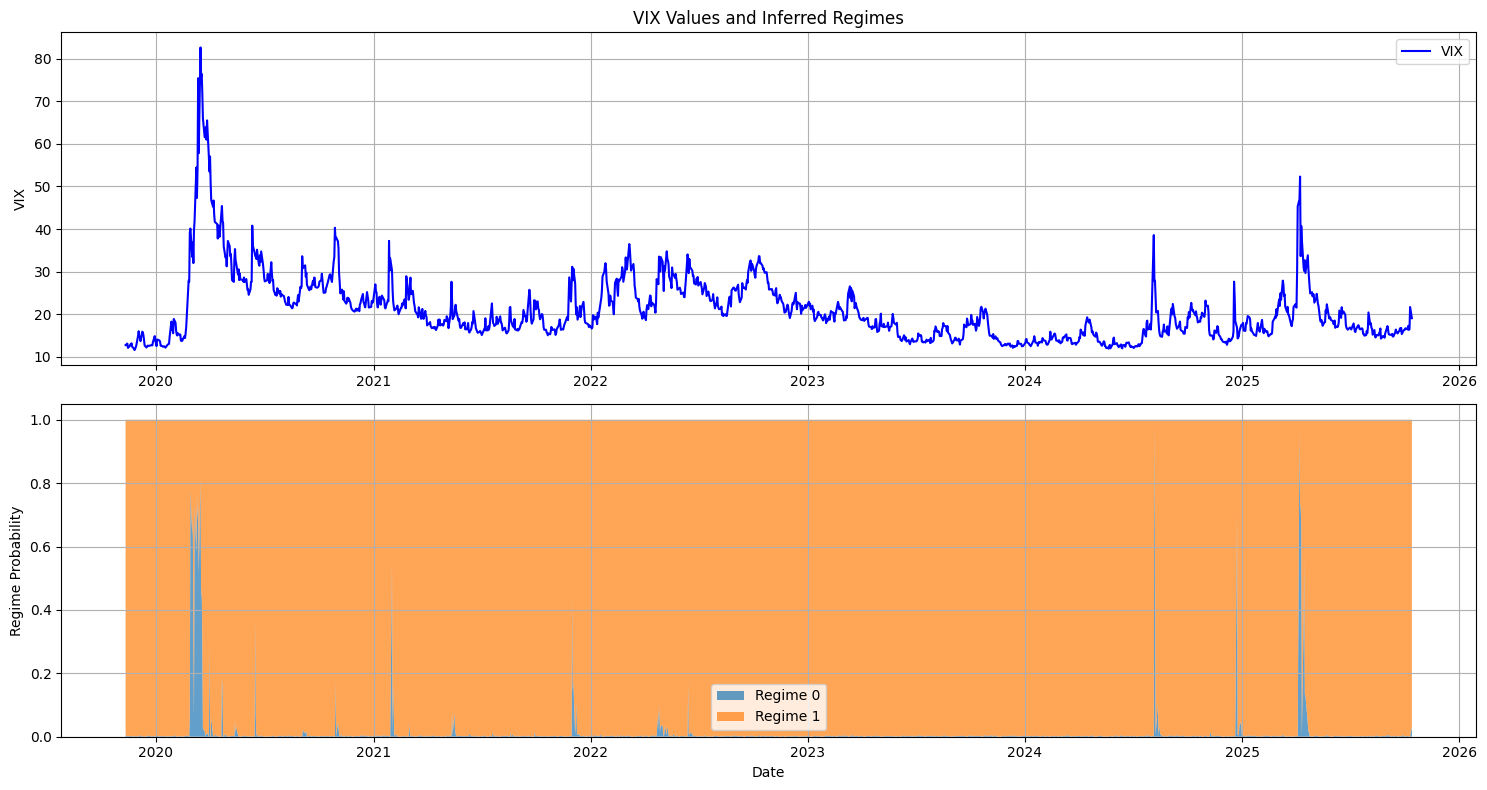

INFO:__main__:Regime 0: 19 days (1.3%)
INFO:__main__:Regime 1: 1469 days (98.7%)
INFO:__main__:
Regime 0 parameters:
INFO:__main__:  kappa: 0.1000
INFO:__main__:  theta: 0.3700
INFO:__main__:  sigma: 2.2393
INFO:__main__:
Regime 1 parameters:
INFO:__main__:  kappa: 20.0000
INFO:__main__:  theta: 0.2051
INFO:__main__:  sigma: 0.3121
INFO:__main__:Regime 1: 1469 days (98.7%)
INFO:__main__:
Regime 0 parameters:
INFO:__main__:  kappa: 0.1000
INFO:__main__:  theta: 0.3700
INFO:__main__:  sigma: 2.2393
INFO:__main__:
Regime 1 parameters:
INFO:__main__:  kappa: 20.0000
INFO:__main__:  theta: 0.2051
INFO:__main__:  sigma: 0.3121


In [7]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Load and prepare data
data_path = os.path.join('..', 'data', '.test', 'long_vix_data.csv')
vix_df = load_vix_data(data_path)
vix_values = vix_df['VIX'].values

# Calibrate the model
logger.info("Calibrating VIX model...")
calibrated_params, _ = calibrate_vix_model(vix_values)

# Create a rolling window of regime inference
window_size = 20
regimes = []
regime_probabilities = []

logger.info("Inferring regimes for each window...")
for i in range(window_size, len(vix_values)):
    window_data = vix_values[i-window_size:i]
    regime, probs = infer_current_regime(window_data, calibrated_params, window_size=window_size)
    regimes.append(regime)
    regime_probabilities.append(probs)

# Convert to arrays
regimes = np.array(regimes)
regime_probabilities = np.array(regime_probabilities)

# Create visualization
plt.figure(figsize=(15, 8))

# Plot VIX values
plt.subplot(211)
plt.plot(vix_df['Date'][window_size:], vix_values[window_size:], 'b-', label='VIX')
plt.title('VIX Values and Inferred Regimes')
plt.ylabel('VIX')
plt.legend()
plt.grid(True)

# Plot regime probabilities
plt.subplot(212)
dates = vix_df['Date'][window_size:]
plt.stackplot(dates, 
             regime_probabilities.T,
             labels=[f'Regime {i}' for i in range(len(calibrated_params['process_params']))],
             alpha=0.7)
plt.ylabel('Regime Probability')
plt.xlabel('Date')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
for i in range(len(calibrated_params['process_params'])):
    regime_days = np.sum(regimes == i)
    regime_pct = regime_days / len(regimes) * 100
    logger.info(f"Regime {i}: {regime_days} days ({regime_pct:.1f}%)")

# Print process parameters for each regime
for i, params in enumerate(calibrated_params['process_params']):
    logger.info(f"\nRegime {i} parameters:")
    for key, value in params.items():
        logger.info(f"  {key}: {value:.4f}")